## Importing Libraries


In [8]:
from tensorflow import keras
from keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint,LambdaCallback
from keras.layers import Input,Dropout, Dense,GlobalAveragePooling2D, BatchNormalization
from keras.models import Sequential,Model
from keras.applications.resnet import ResNet50
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import load_img
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import tensorflow as tf
from tqdm import tqdm
import seaborn as sns
import numpy as np
import itertools 
import datetime
import cv2
import os
import io

In [9]:
IMAGE_SIZE = 224
BATCH_SIZE = 16  # Reduce batch size

TRAIN_PATH = "D:/white_bloodcell_cnn/data/Train"
TEST_PATH = "D:/white_bloodcell_cnn/data/Test-A"

data_gen = ImageDataGenerator(
    rescale=1./255,
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=0.2
)

train_gen = data_gen.flow_from_directory(
    directory=TRAIN_PATH,
    subset='training',
    batch_size=BATCH_SIZE,
    shuffle=True,
    class_mode='categorical',
    target_size=(IMAGE_SIZE, IMAGE_SIZE)
)

valid_gen = data_gen.flow_from_directory(
    directory=TRAIN_PATH,
    subset='validation',
    batch_size=BATCH_SIZE,
    shuffle=False,
    class_mode='categorical',
    target_size=(IMAGE_SIZE, IMAGE_SIZE)
)

test_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
    directory=TEST_PATH,
    batch_size=BATCH_SIZE,
    shuffle=False,
    class_mode='categorical',
    target_size=(IMAGE_SIZE, IMAGE_SIZE)
)

Found 8142 images belonging to 5 classes.
Found 2033 images belonging to 5 classes.
Found 4339 images belonging to 5 classes.


## Visualize Data

In [3]:
'''# plot some image of our dataset
import matplotlib.pyplot as plt
import numpy as np

labels = ['Basophil', 'Eosinophil', 'Lymphocyte', 'Monocyte','Neutrophil']

image,label = train_gen.next()

plt.figure(figsize = (12,12))
for i in range(6) :
    plt.subplot(4, 4, i+1)
    plt.imshow(image[i])
    plt.title(labels[np.argmax(label[i])])
    plt.axis('off')
plt.show()'''

"# plot some image of our dataset\nimport matplotlib.pyplot as plt\nimport numpy as np\n\nlabels = ['Basophil', 'Eosinophil', 'Lymphocyte', 'Monocyte','Neutrophil']\n\nimage,label = train_gen.next()\n\nplt.figure(figsize = (12,12))\nfor i in range(6) :\n    plt.subplot(4, 4, i+1)\n    plt.imshow(image[i])\n    plt.title(labels[np.argmax(label[i])])\n    plt.axis('off')\nplt.show()"

In [4]:
base_model = keras.applications.MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)
)
# net.trainable = False

9406464/9406464 [==============================] - 3s 0us/step


In [5]:
model = base_model.output
model = GlobalAveragePooling2D()(model)
model = BatchNormalization()(model)
model = Dropout(0.2)(model)
model = Dense(5, activation="softmax")(model)
model = Model(inputs=base_model.input, outputs=model)

adam = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

                                                                                                  
 expanded_conv_project (Conv2D)  (None, 112, 112, 16  512        ['expanded_conv_depthwise_relu[0]
                                )                                [0]']                            
                                                                                                  
 expanded_conv_project_BN (Batc  (None, 112, 112, 16  64         ['expanded_conv_project[0][0]']  
 hNormalization)                )                                                                 
                                                                                                  
 block_1_expand (Conv2D)        (None, 112, 112, 96  1536        ['expanded_conv_project_BN[0][0]'
                                )                                ]                                
                                                                                                  
 block_1_e

## Fitting Model

In [7]:
BATCH_SIZE = 32  # Adjust batch size back to original value
EPOCHS = 10

ES = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=5, mode='min', restore_best_weights=True, verbose=1)
RL = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=5, verbose=1, mode='min')

callbacks = [ES, RL]

history = model.fit(train_gen, validation_data=valid_gen, epochs=EPOCHS, callbacks=callbacks)

Epoch 1/10
509/509 [==============================] - 91s 177ms/step - loss: 0.0214 - accuracy: 0.9936 - val_loss: 0.7156 - val_accuracy: 0.8992 - lr: 1.0000e-04
Epoch 2/10
509/509 [==============================] - 90s 177ms/step - loss: 0.0226 - accuracy: 0.9935 - val_loss: 0.3914 - val_accuracy: 0.9306 - lr: 1.0000e-04
Epoch 3/10
509/509 [==============================] - 90s 177ms/step - loss: 0.0129 - accuracy: 0.9951 - val_loss: 0.5567 - val_accuracy: 0.9139 - lr: 1.0000e-04
Epoch 4/10
509/509 [==============================] - 91s 178ms/step - loss: 0.0150 - accuracy: 0.9955 - val_loss: 0.3594 - val_accuracy: 0.9292 - lr: 1.0000e-04
Epoch 5/10
509/509 [==============================] - 91s 178ms/step - loss: 0.0211 - accuracy: 0.9951 - val_loss: 0.2655 - val_accuracy: 0.9420 - lr: 1.0000e-04
Epoch 6/10
509/509 [==============================] - 91s 178ms/step - loss: 0.0291 - accuracy: 0.9920 - val_loss: 0.4399 - val_accuracy: 0.9105 - lr: 1.0000e-04
Epoch 7/10
509/509 [========

## Learning curves

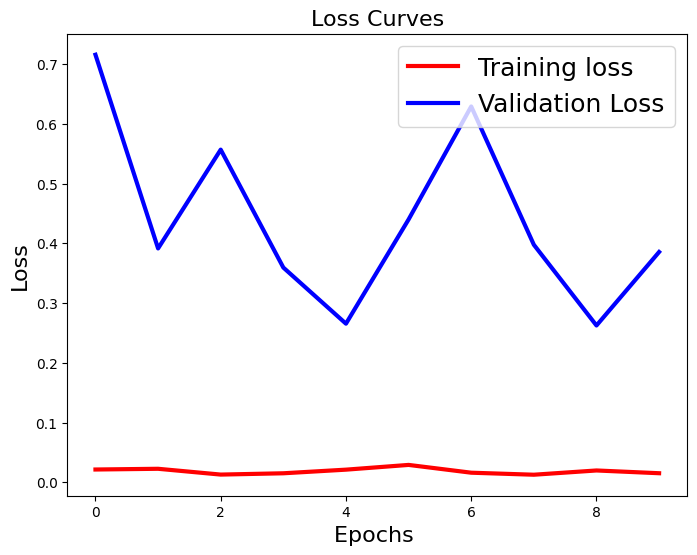

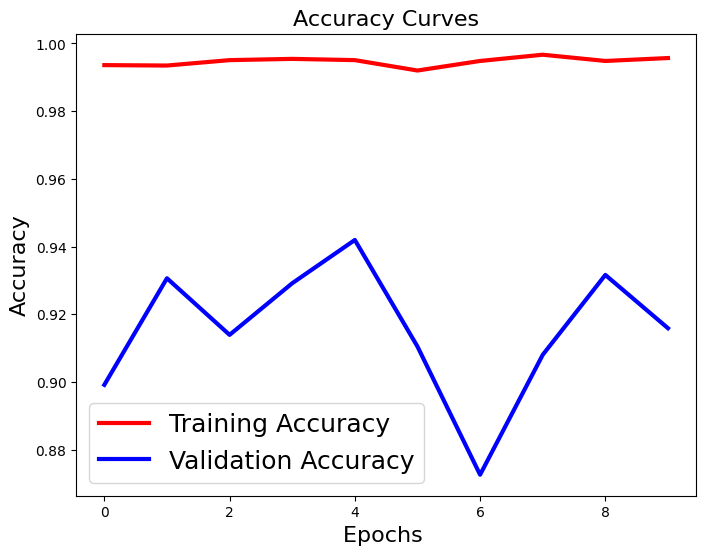

In [8]:
#Plot the Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
plt.show()

#Plot the Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['accuracy'],'r',linewidth=3.0)
plt.plot(history.history['val_accuracy'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)   
plt.show()

## Evaluation Metrics

272/272 [==============================] - 18s 64ms/step
              precision    recall  f1-score   support

           0       0.74      1.00      0.85        89
           1       0.93      0.98      0.96       322
           2       0.99      0.96      0.97      1034
           3       0.93      0.95      0.94       234
           4       1.00      0.99      0.99      2660

    accuracy                           0.98      4339
   macro avg       0.92      0.97      0.94      4339
weighted avg       0.98      0.98      0.98      4339



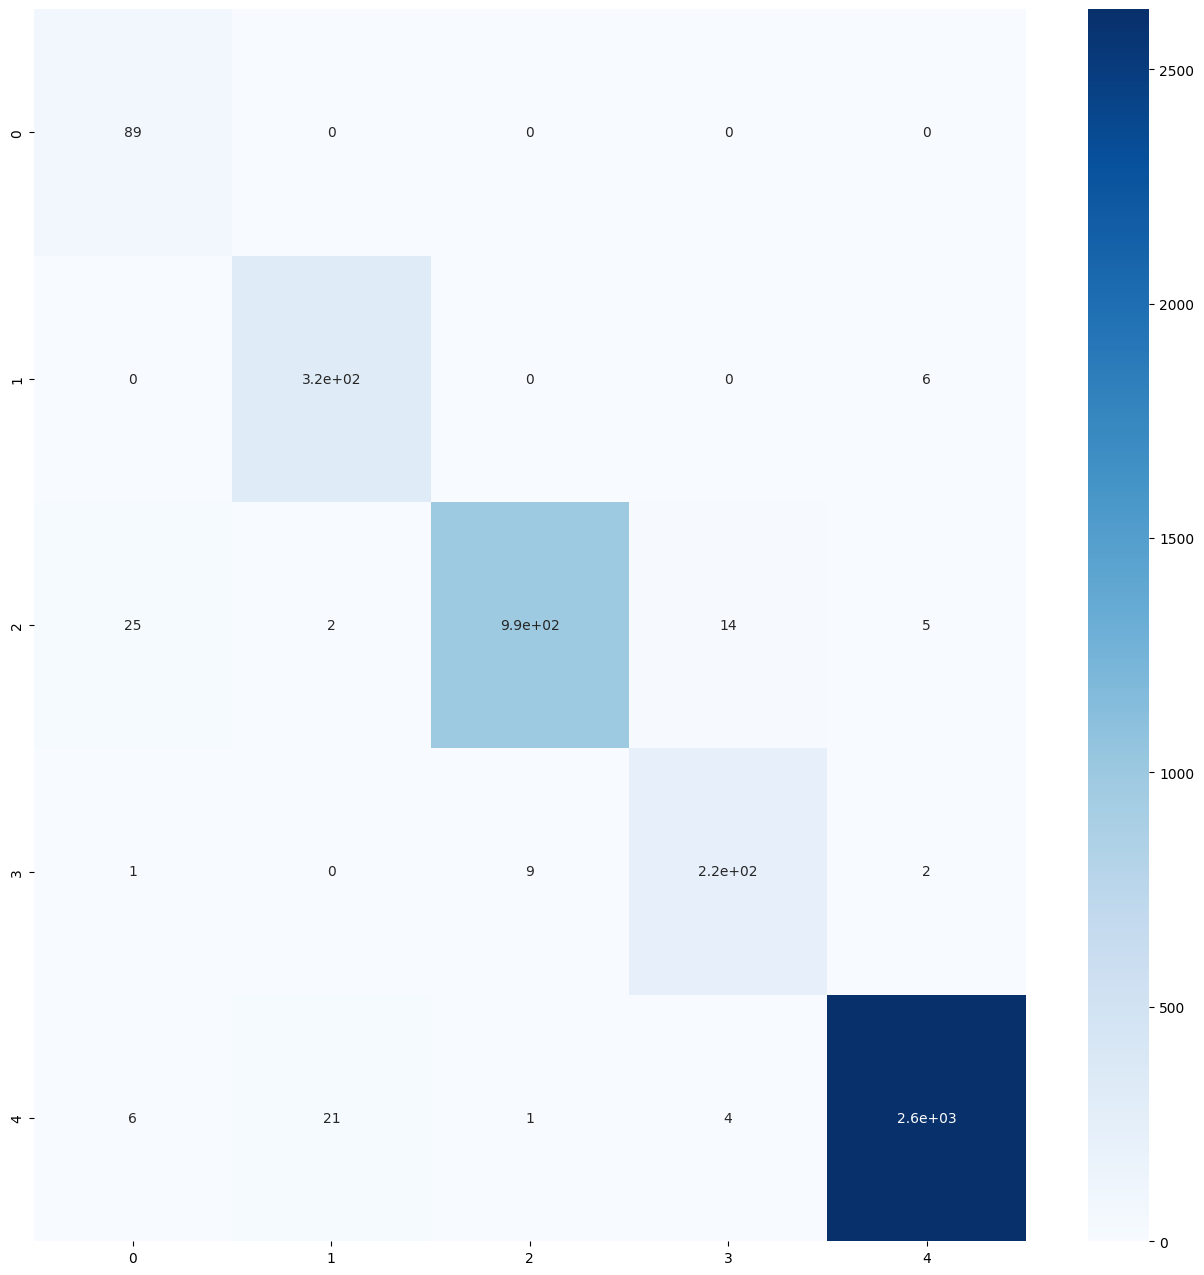

In [9]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

predicted_classes = np.argmax(model.predict(test_gen), axis = 1)

confusionmatrix = confusion_matrix(test_gen.classes, predicted_classes)
plt.figure(figsize = (16, 16))
sns.heatmap(confusionmatrix, cmap = 'Blues', annot = True, cbar = True)

print(classification_report(test_gen.classes, predicted_classes))

## Testing Loss & Accuracy

In [10]:
loss,acc = model.evaluate(test_gen)

272/272 [==============================] - 12s 44ms/step - loss: 0.0854 - accuracy: 0.9779


In [11]:
model.save("model.h5")
print("Done")

Done


In [10]:
class_indices = train_gen.class_indices
class_names = {v: k for k, v in class_indices.items()}
sorted_class_names = [class_names[i] for i in range(len(class_names))]
print("Class names in order:")
for class_name in sorted_class_names:
    print(class_name)


Class names in order:
Basophil
Eosinophil
Lymphocyte
Monocyte
Neutrophil


In [18]:
from tensorflow import keras
from PIL import Image
import numpy as np

model = keras.models.load_model('model.h5')
def preprocess_image(image_path):
    img = Image.open(image_path).resize((224, 224))
    img_array = np.array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

new_image_path = 'e.jpg'
new_image = preprocess_image(new_image_path)
predictions = model.predict(new_image)
predicted_class = np.argmax(predictions)
print("Predicted class:", predicted_class)

# order of cell types ['Basophil', 'Eosinophil', 'Lymphocyte', 'Monocyte','Neutrophil']
def get_class_name(predicted_class):
    labels = ['Basophil', 'Eosinophil', 'Lymphocyte', 'Monocyte', 'Neutrophil']
    return labels[predicted_class]

class_name = get_class_name(predicted_class)
print("class name:", class_name)


1/1 [==============================] - 2s 2s/step
Predicted class: 1
class name: Eosinophil
